<a href="https://colab.research.google.com/github/nicoaira/Wiener-Fold/blob/main/Deep_EXPAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations & Imports

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Input, Flatten
from keras.callbacks import EarlyStopping
from keras import regularizers
import pandas as pd
import numpy as np
import os
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import keras_tuner as kt
# from datetime import datetime
# from packaging import version
# import tensorboard
# import visualkeras

# Data pre-processing

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

%cd gdrive/MyDrive/EXPAR

ds = pd.read_csv('expar_dataset.txt', sep=' ', index_col='id')

Mounted at /content/gdrive
/content/gdrive/MyDrive/EXPAR


In [ ]:
def preprocessing(target = 'class', drop_class_3 = True, ds = ds):

  ds = ds.copy()

  ds = ds[(ds['diff'] != 0) & (ds['p90'] != 0) & (ds['sequence'].str.len() == 30) ]

  if target == 'class':

    ds['metric'] = ds['p90'] * 0.85 - ds['diff']
    ds['class'] = np.where(((ds['metric'] <= 15.0) & (ds['diff'] >= 1.0)) , 1,
                                np.where(((ds['metric'] >= 15.0) & (ds['diff'] <= -1.3)) , 0,
                                         2))
    
    ds = ds[ds.columns.drop(['results', 'metric'])]

    if drop_class_3:
      ds = ds[ds['class'] != 2]

  return ds

In [ ]:
ds = preprocessing(target = 'class', drop_class_3 = False)

In [ ]:
ds.head(8)

,sequence,tm1,tm2,#bonds,p90,n10,diff,class
id,,,,,,,,
1,CCTACGACTGAACAGACTCTCCTACGACTG,43,15,6,12.6,16.6,4.0,1
2,CCTACGACTTAACAGACTCTCCTACGACTT,39,-25,2,16.3,21.4,5.1,1
3,CCTACGACGGAACAGACTCTCCTACGACGG,48,-25,2,15.4,16.5,1.2,1
4,CCTACGAGTGAACAGACTCTCCTACGAGTG,43,-25,2,17.8,17.8,0.1,2
5,CCTACGGCTGAACAGACTCTCCTACGGCTG,48,2,6,12.5,12.0,-0.5,2
6,CCTACTACTGAACAGACTCTCCTACTACTG,36,15,6,18.8,23.8,5.0,1
8,CCTGCGACTGAACAGACTCTCCTGCGACTG,49,15,6,11.9,13.2,1.3,1
9,CCAACGACTGAACAGACTCTCCAACGACTG,45,15,6,24.0,27.7,3.7,2


## kmers_mapping

Creates a dictionary that maps each k-mer to an unique index

In [ ]:
def kmers_mapping(dataset, k_i, k_f):

  kmers_mapping_dict = {}

  for k in range(k_i, k_f+1):
    k_mers = {}

    for seq in dataset['sequence']:
      n_bases = len(seq)

      for i in range(0,n_bases + 1 - k):
        k_mer = seq[0+i: k+i]
        
        if k_mer not in k_mers.keys():
          k_mers[k_mer] = 1


    k_mers_to_index = {}

    for index, key in enumerate(k_mers.keys()):
      k_mers_to_index[key] = index

    kmers_mapping_dict[k] = k_mers_to_index

  return  kmers_mapping_dict

##one_hot_kmer

Encondes the sequences into one-hot vectors for each k-mer in the sequence

In [ ]:
def one_hot_kmer(dataset, k, kmers_mapping_dict):

  k_mers = {}

  for seq in dataset['sequence']:
    n_bases = len(seq)

    for i in range(0,n_bases + 1 - k):
      k_mer = seq[0+i: k+i]
      
      if k_mer in k_mers.keys():
        k_mers[k_mer] += 1

      else:
        k_mers[k_mer] = 1

  unique_kmers = len(kmers_mapping_dict)
  onehot_kmers = np.zeros(shape=(dataset.shape[0],31-k,unique_kmers))

  for seq_n, seq in enumerate(dataset['sequence']):
    n_bases = len(seq)

    for i in range(0,n_bases + 1 - k):

      k_mer = seq[0+i: k+i]
      k_index = kmers_mapping_dict[k_mer]
      onehot_kmers[seq_n][i][k_index] = 1

  return onehot_kmers

## gen_dataset

It creates the dataset objects

In [ ]:
def gen_datasets(ds, label, validation_split = 0.2, 
                 k_i = 1, k_f = 4, BATCH_SIZE = 8, training = True):
  
  if training:
    ds = ds.sample(frac=1)
  
  if validation_split > 0:
    train_size = int(ds.shape[0]*(1-validation_split))
    test_ds = ds[train_size:]
    train_ds = ds[:train_size]

  else:
    train_ds = ds


  train_datasets = {}
  test_datasets = {}

  dict_to_ds_train = {}
  dict_to_ds_test = {}

  
  train_thermo = tf.convert_to_tensor(train_ds.loc[:,['tm1', 'tm2','#bonds']])
  dict_to_ds_train['thermo'] = train_thermo
  train_datasets['thermo'] = train_thermo

  if validation_split > 0:
    test_thermo = tf.convert_to_tensor(test_ds.loc[:,['tm1', 'tm2','#bonds']])
    dict_to_ds_test['thermo'] = test_thermo
    test_datasets['thermo'] = test_thermo


  kmers_mapping_dict = kmers_mapping(preprocessing(target = 'p90'), k_i, k_f)

  for k in range(k_i, k_f + 1):
    train_kmer = tf.convert_to_tensor(one_hot_kmer(train_ds, k, kmers_mapping_dict[k]))
    dict_to_ds_train[str(k)] = train_kmer
    train_datasets[k] = train_kmer

    if validation_split > 0:
      test_kmer = tf.convert_to_tensor(one_hot_kmer(test_ds, k, kmers_mapping_dict[k]))
      dict_to_ds_test[str(k)] = test_kmer
      test_datasets[k] = test_kmer

  if label == 'class':
    train_labels= tf.convert_to_tensor(train_ds[label])
    train_kmer_ds = tf.data.Dataset.from_tensor_slices((dict_to_ds_train, train_labels))
    train_kmer_ds = train_kmer_ds.batch(BATCH_SIZE)

    if validation_split > 0:
      test_labels = tf.convert_to_tensor(test_ds[label])
      test_kmer_ds = tf.data.Dataset.from_tensor_slices((dict_to_ds_test, test_labels))
      test_kmer_ds = test_kmer_ds.batch(BATCH_SIZE)

  else:
    dict_to_label_train = {}

    train_labels_p90 = tf.convert_to_tensor(train_ds['p90'])
    dict_to_label_train['p90'] = train_labels_p90
    train_labels_n10 = tf.convert_to_tensor(train_ds['n10'])
    dict_to_label_train['n10'] = train_labels_n10


    train_kmer_ds = tf.data.Dataset.from_tensor_slices((dict_to_ds_train, dict_to_label_train))
    train_kmer_ds = train_kmer_ds.batch(BATCH_SIZE)

    if validation_split > 0:

      dict_to_label_test = {}
      test_labels_p90 = tf.convert_to_tensor(test_ds['p90'])
      dict_to_label_test['p90'] = test_labels_p90
      test_labels_n10 = tf.convert_to_tensor(test_ds['n10'])
      dict_to_label_test['n10'] = test_labels_n10

      test_kmer_ds = tf.data.Dataset.from_tensor_slices((dict_to_ds_test, dict_to_label_test))
      test_kmer_ds = test_kmer_ds.batch(BATCH_SIZE)
    
  if validation_split == 0:
    test_kmer_ds = None
    test_datasets = None
    test_ds = None

  return train_kmer_ds, test_kmer_ds, train_datasets, test_datasets, test_ds

#P90 MODEL

This model uses the whole dataset in order to predict the values p90 and n10

In [ ]:
def build_model_p90(k_i = 1, k_f = 4, BATCH_SIZE = 64, val_split = 0.2):

  target = 'p90'
  ds = preprocessing(target = target)
  train_kmer_ds, test_kmer_ds, train_datasets, _, _= gen_datasets(ds,
                                                                target,
                                                                k_i = k_i,
                                                                k_f = k_f,
                                                                BATCH_SIZE = BATCH_SIZE,
                                                                validation_split = val_split)



  inputs_layers = []
  concat_layers= []

  input = Input(shape=(train_datasets['thermo'].shape[1], ), name = 'thermo')
  inputs_layers.append(input)
  x = Dense(4,activity_regularizer=tf.keras.regularizers.l2(0.1), name ='thermo_dense')(input)
  x = Dropout(0.1, name ='thermo_dropout')(x)

  concat_layers.append(x)


  for k in range(k_i, k_f+1):
    kmers = train_datasets[k].shape[1]
    unique_kmers = train_datasets[k].shape[2]
    input = Input(shape=(kmers, unique_kmers))
    inputs_layers.append(input)
  

    x = Dense(4,activity_regularizer=tf.keras.regularizers.l2(0.05))(input)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    concat_layers.append(x)

  inputs = keras.layers.concatenate(concat_layers, name='concat_layer')



  x = Dense(2, activation='relu', 
            activity_regularizer=tf.keras.regularizers.l2(0.2))(inputs)
  x = Dropout(0.3)(x)
  # x = Dense(4, activation='relu',activity_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Flatten()(x)


  x_p90 = Dense(8, activation='relu',
                activity_regularizer=tf.keras.regularizers.l2(0.2),
                name='dense_p90')(x)


  x_p90 = Dropout(0.25)(x_p90)
  output_p90 = Dense(1, activation='linear', name='p90')(x_p90)

  x_n10 = Dense(8, activation='relu',
                activity_regularizer=tf.keras.regularizers.l2(0.2),
                name='dense_n10')(x)
  x_n10 = Dropout(0.25)(x_n10)
  output_n10 = outputs = Dense(1, activation='linear', name='n10')(x_n10)


  outputs = [output_p90, output_n10]

  
  model_p90 = keras.Model(inputs=inputs_layers, outputs=outputs)


  for i in range(k_i -1, k_f):
   model_p90.layers[i]._name = str(i+1)
  

  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=800,
    decay_rate=0.95)

  optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
  model_p90.compile(loss='mse', optimizer = optimizer)
  

  return model_p90, train_kmer_ds, test_kmer_ds,

In [ ]:
def train_model_p90(k_i = 1, k_f = 4, BATCH_SIZE = 64, verbose = 2,
                    val_split = 0.2):

  model_p90, train_kmer_ds, test_kmer_ds = build_model_p90(k_i = k_i,
                              k_f = k_f,
                              BATCH_SIZE = BATCH_SIZE,
                              val_split = val_split)
  

  if val_split > 0:
    monitor = 'val_loss'
  else:
    monitor = 'loss'

  stop_early = EarlyStopping(monitor=monitor,                           
    patience=10,
    verbose=0,
    min_delta = 0.02,
    mode="auto",
    restore_best_weights=True)
  
  # logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
  #                                                    write_graph = True)
  

  if val_split > 0:

    history_p90 = model_p90.fit(train_kmer_ds, epochs=500, 
                                batch_size = BATCH_SIZE,verbose = verbose,
                                validation_data = test_kmer_ds,
                                callbacks = [stop_early])
    
  else:
    history_p90 = model_p90.fit(train_kmer_ds, epochs=500, 
                                batch_size = BATCH_SIZE, verbose = verbose,
                                callbacks = [stop_early])
      
  return model_p90, history_p90

In [ ]:
model_p90, history_p90 = train_model_p90(k_i = 1, k_f = 4, BATCH_SIZE = 64)

Epoch 1/500
4/4 - 15s - loss: 1428.7732 - p90_loss: 525.1879 - n10_loss: 489.6162 - val_loss: 1503.6619 - val_p90_loss: 555.5280 - val_n10_loss: 541.4205 - 15s/epoch - 4s/step
Epoch 2/500
4/4 - 0s - loss: 1389.2585 - p90_loss: 526.1147 - n10_loss: 477.2355 - val_loss: 1473.6782 - val_p90_loss: 557.1099 - val_n10_loss: 535.0891 - 126ms/epoch - 31ms/step
Epoch 3/500
4/4 - 0s - loss: 1360.6373 - p90_loss: 525.0340 - n10_loss: 474.0426 - val_loss: 1446.5985 - val_p90_loss: 555.9713 - val_n10_loss: 532.1502 - 129ms/epoch - 32ms/step
Epoch 4/500
4/4 - 0s - loss: 1335.8785 - p90_loss: 524.1360 - n10_loss: 472.0802 - val_loss: 1418.1074 - val_p90_loss: 552.3112 - val_n10_loss: 528.6010 - 124ms/epoch - 31ms/step
Epoch 5/500
4/4 - 0s - loss: 1307.0056 - p90_loss: 518.9513 - n10_loss: 468.1191 - val_loss: 1377.9106 - val_p90_loss: 538.6890 - val_n10_loss: 520.3448 - 135ms/epoch - 34ms/step
Epoch 6/500
4/4 - 0s - loss: 1258.5076 - p90_loss: 499.9403 - n10_loss: 453.3414 - val_loss: 1310.7395 - val

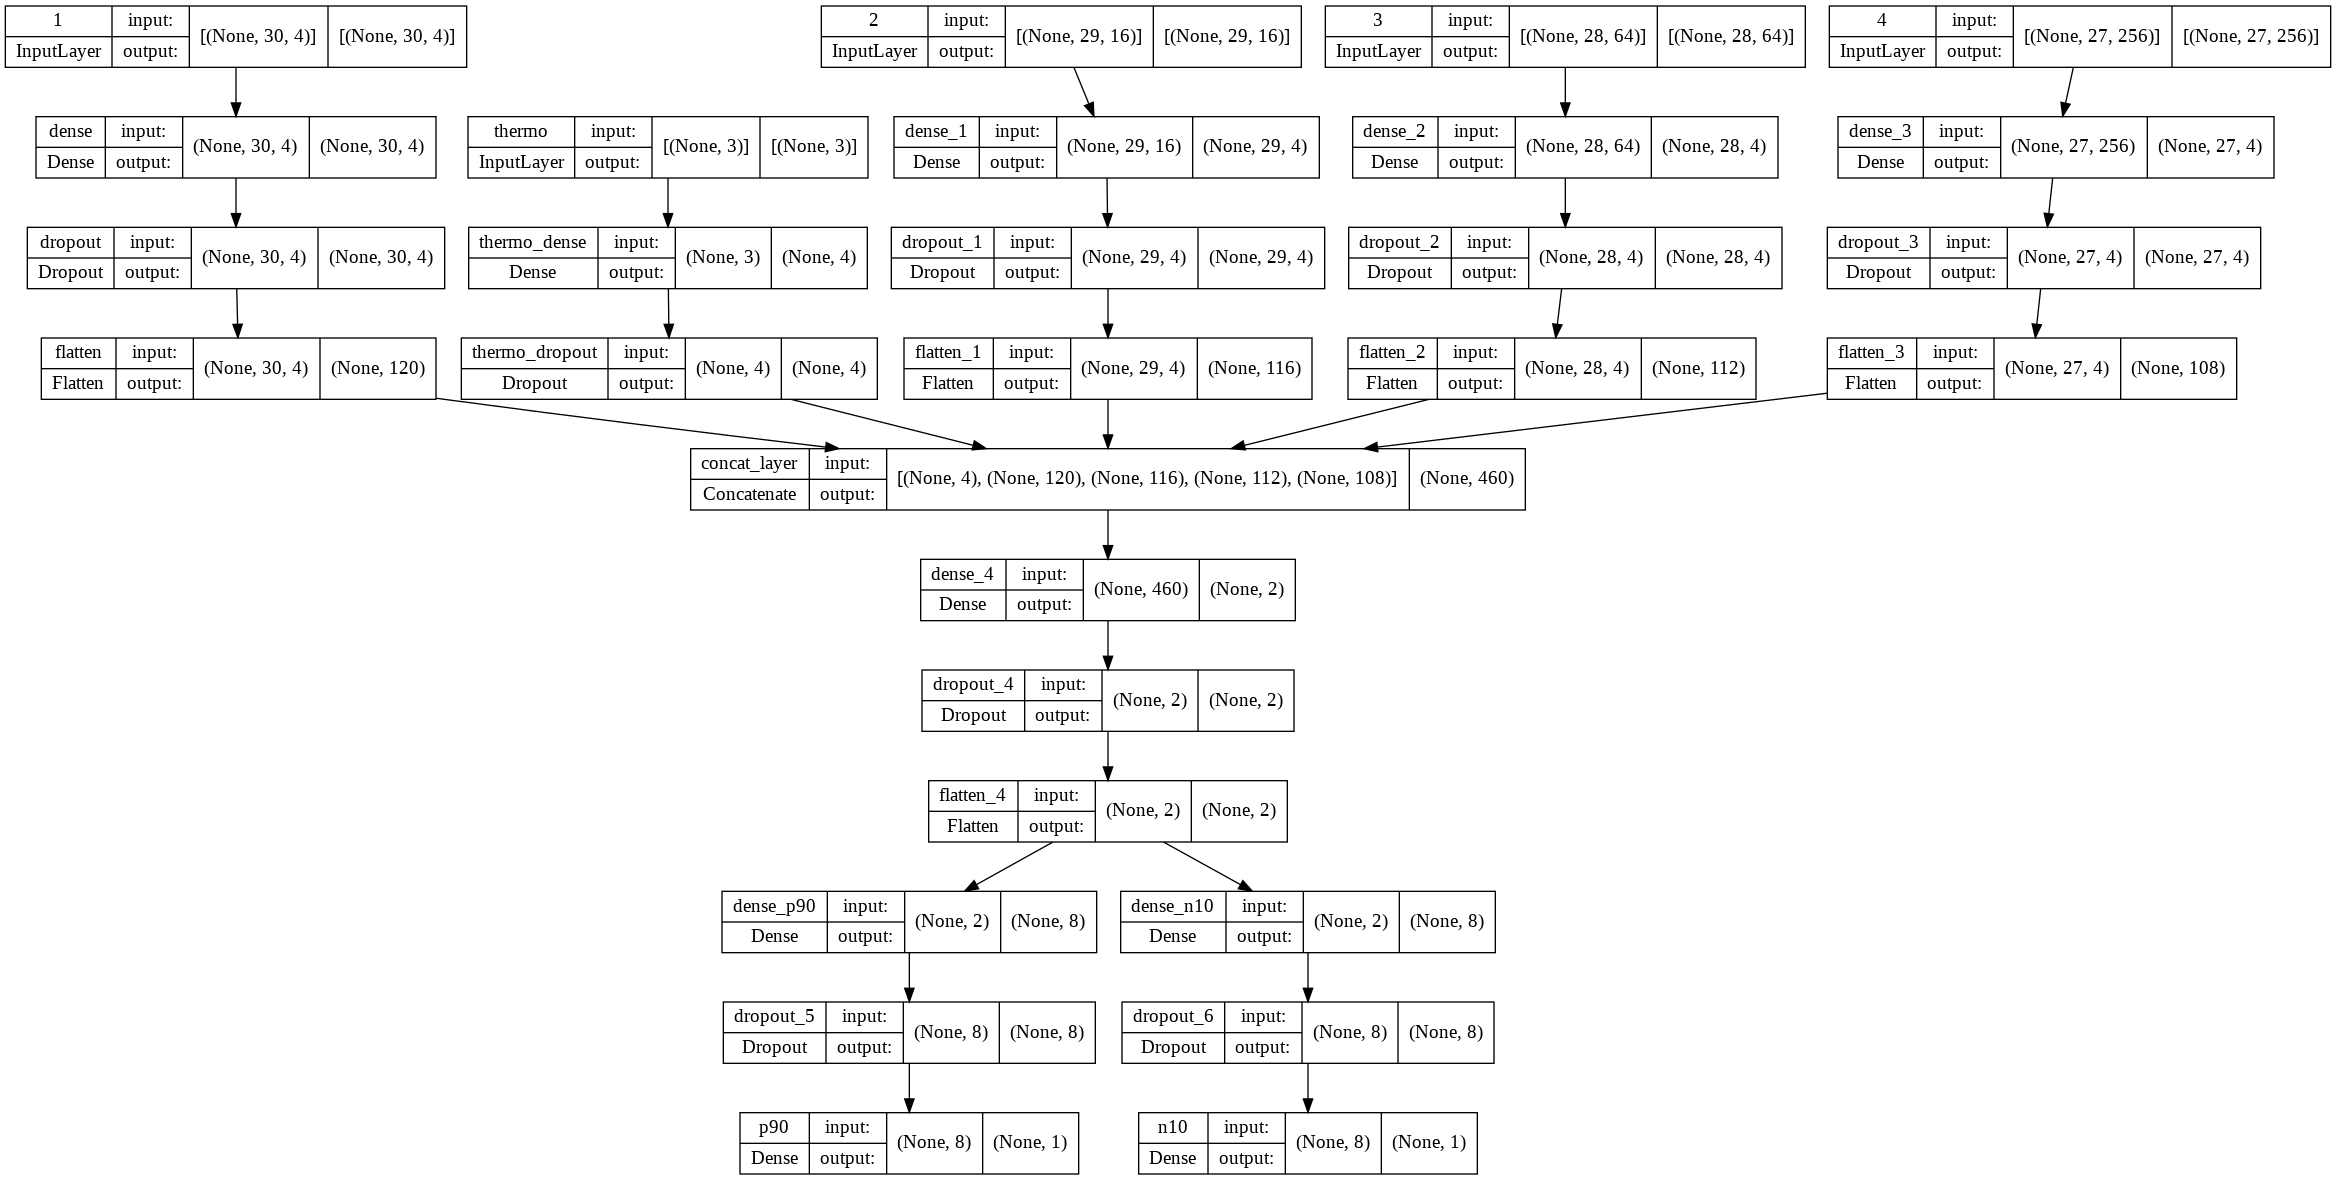

In [ ]:
tf.keras.utils.plot_model(model_p90, to_file='model.png', show_shapes=True, show_layer_names=True)

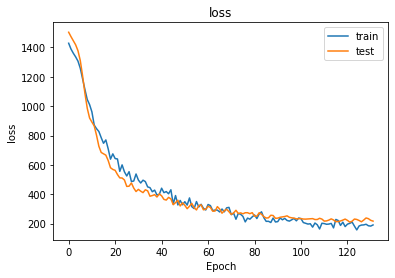

In [ ]:
plt.plot(history_p90.history['loss'])
plt.plot(history_p90.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# CLASS MODEL

This model uses pretrained layers of the P90 model and adds a final trainable dense layer that helps in the classification of the sequences in class I or class II.

Since around 35% of the dataset its class III, but this group is not used for evalutating the model, here we will use only the dataset where class = I or II.

In [ ]:
def build_model_class(k_i = 1, k_f = 4, BATCH_SIZE = 64, val_split = 0.2):

  

  model_p90, _ = train_model_p90(k_i = k_i, k_f = k_f, BATCH_SIZE = BATCH_SIZE,
                               verbose = 0, val_split = val_split)
  
  target = 'class'
  
  ds = preprocessing(target = target)

  
  _, _, train_datasets, _, _ = gen_datasets(ds,
                                            target,
                                            k_i = k_i,
                                            k_f = k_f,
                                            BATCH_SIZE = BATCH_SIZE,
                                            validation_split = val_split)

  inputs_layers = []
  concat_layers= []

  input = Input(shape=(train_datasets['thermo'].shape[1], ), name = 'thermo')
  inputs_layers.append(input)
  x = model_p90.layers[k_f*2+1](input) # Dense
  x = model_p90.layers[k_f*3+2](x) # Dropout
  concat_layers.append(x)


  for k in range(k_i-1, k_f):    
    kmers = train_datasets[k+1].shape[1]
    unique_kmers = train_datasets[k+1].shape[2]
    input = Input(shape=(kmers, unique_kmers))
    x = model_p90.layers[k + k_f + 1](input) # Dense
    model_p90.layers[k + k_f + 1].trainable = True
    x = model_p90.layers[k + k_f*2 + 2](x) # Dropout
    x = model_p90.layers[k + k_f*3 + 3](x) # Flatten

    inputs_layers.append(input)
    concat_layers.append(x)
    
  inputs = keras.layers.concatenate(concat_layers, name='concat_layer')

  x = model_p90.layers[k_f*4+4](inputs)
  model_p90.layers[k_f*4+4].trainable = True


  for layer in model_p90.layers[k_f*4+5:-6]:
    x = layer(x)
    layer.trainable = True

  x_p90 = model_p90.layers[-6](x)
  x_p90 =  model_p90.layers[-4](x_p90)
  model_p90.layers[-4].trainable = True
  # x_p90 =  model_p90.layers[-2](x_p90)
  # model_p90.layers[-2].trainable = False

  x_n10 =  model_p90.layers[-5](x)
  model_p90.layers[-5].trainable = True
  x_n10 =  model_p90.layers[-3](x_n10)
  model_p90.layers[-3].trainable = True
  # x_n10 =  model_p90.layers[-1](x_n10)
  # model_p90.layers[-1].trainable = False

  final_concat = keras.layers.concatenate([x_p90, x_n10], name='final_concat')

  x = Dense(8,activity_regularizer=tf.keras.regularizers.l2(0))(final_concat)
  x = Dense(8,activity_regularizer=tf.keras.regularizers.l2(0))(x)
  x = Dense(4,activity_regularizer=tf.keras.regularizers.l2(0))(x)


  outputs = Dense(1, activation='sigmoid', name='class')(x)


  model_class = keras.Model(inputs=inputs_layers, outputs=outputs)

  for i in range(k_i-1, k_f):
    model_class.layers[i]._name = str(i+1)

  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=5e-3,
  decay_steps=1000,
  decay_rate=0.85)


  optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
  model_class.compile(loss='binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])


  return model_class

In [ ]:
def train_model_class(k_i = 1, k_f = 4, BATCH_SIZE = 64, verbose = 2,
                      val_split = 0.2):

  BATCH_SIZE = 64
  target = 'class'

  model_class =  build_model_class(k_i = k_i, k_f = k_f, BATCH_SIZE = 64)

  ds = preprocessing(target = target)

  train_kmer_ds, test_kmer_ds, _, _, test_ds = gen_datasets(ds,
                                              target,
                                              k_i = k_i,
                                              k_f = k_f,
                                              BATCH_SIZE = BATCH_SIZE)
  

  if val_split > 0:
    monitor = 'val_loss'
  else:
    monitor = 'loss'
   

  stop_early = EarlyStopping(monitor=monitor,                           
  patience=15,
  verbose=0,
  mode="auto",
  restore_best_weights=True)

  # logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
  #                                                    write_graph = True)

  if val_split > 0:
    history_class = model_class.fit(train_kmer_ds, epochs=500,
                                      batch_size = BATCH_SIZE,verbose = verbose, 
                                      validation_data = test_kmer_ds,
                                      callbacks = [stop_early])

  else:
    history_class = model_class.fit(train_kmer_ds, epochs=500,
                                    batch_size = BATCH_SIZE,verbose = verbose, 
                                    callbacks = [stop_early])
    test_kmer_ds = None
    test_ds = None
  
  return model_class, history_class, test_kmer_ds, test_ds

In [ ]:
model_class, history_class,test_kmer_ds, test_ds = train_model_class(k_i = 1, 
                                          k_f = 4, 
                                          BATCH_SIZE = 64, 
                                          verbose = 2)

Epoch 1/500
3/3 - 4s - loss: 19.4650 - accuracy: 0.3988 - val_loss: 9.4727 - val_accuracy: 0.2439 - 4s/epoch - 1s/step
Epoch 2/500
3/3 - 0s - loss: 12.0342 - accuracy: 0.5031 - val_loss: 8.0169 - val_accuracy: 0.2683 - 66ms/epoch - 22ms/step
Epoch 3/500
3/3 - 0s - loss: 9.5495 - accuracy: 0.5031 - val_loss: 7.2223 - val_accuracy: 0.2683 - 70ms/epoch - 23ms/step
Epoch 4/500
3/3 - 0s - loss: 7.9269 - accuracy: 0.5092 - val_loss: 6.7639 - val_accuracy: 0.2683 - 71ms/epoch - 24ms/step
Epoch 5/500
3/3 - 0s - loss: 7.1274 - accuracy: 0.5460 - val_loss: 6.4464 - val_accuracy: 0.2683 - 69ms/epoch - 23ms/step
Epoch 6/500
3/3 - 0s - loss: 6.4721 - accuracy: 0.5583 - val_loss: 6.2225 - val_accuracy: 0.2683 - 82ms/epoch - 27ms/step
Epoch 7/500
3/3 - 0s - loss: 6.3593 - accuracy: 0.5399 - val_loss: 6.0610 - val_accuracy: 0.2683 - 77ms/epoch - 26ms/step
Epoch 8/500
3/3 - 0s - loss: 6.1381 - accuracy: 0.5890 - val_loss: 5.9391 - val_accuracy: 0.2683 - 71ms/epoch - 24ms/step
Epoch 9/500
3/3 - 0s - los

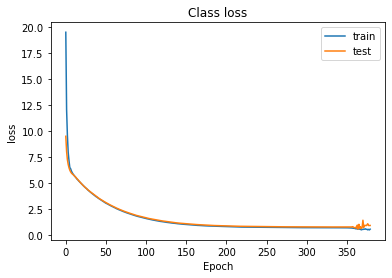

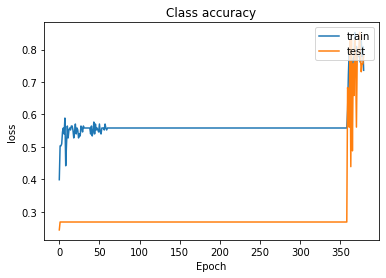

In [ ]:
plt.plot(history_class.history['loss'])
plt.plot(history_class.history['val_loss'])
plt.title('Class loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history_class.history['accuracy'])
plt.plot(history_class.history['val_accuracy'])
plt.title('Class accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
target = 'class'

pred_binary = np.where((model_class.predict(test_kmer_ds) <= 0.5) , 0, 1).reshape(-1)

cm = tf.math.confusion_matrix(
    test_ds[target], pred_binary)

cm = cm.numpy()

actual_class = np.where(np.array(test_ds[target]) == 1, 'I', 'II')
pred_binary = np.where(pred_binary == 1, 'I', 'II')

print('Confusion Matrix\n')
data = {'y_Actual': actual_class,
        'y_Predicted': pred_binary
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

print(confusion_matrix,'\n')

specificity = cm[0,0]/ np.sum(cm, axis = 1)[0]
sensitivity = cm[1,1]/np.sum(cm, axis = 1)[1]


print('Specificity = '+ str(round(specificity*100,2))+'%')
print('Sensitivity = '+ str(round(sensitivity*100,2))+'%')

Confusion Matrix

Predicted   I  II
Actual           
I          29   1
II          6   5 

Specificity = 45.45%
Sensitivity = 96.67%


In [ ]:
model_accuracy = model_class.evaluate(test_kmer_ds, batch_size=64, verbose=1)

1/1 [==============================] - 0s 25ms/step - loss: 0.5539 - accuracy: 0.8293


In [ ]:
pred_binary = np.where((model_class.predict(test_kmer_ds) <= 0.5) , 0, 1).reshape(-1)

columnas=list(zip(test_ds[target], pred_binary))



predicciones = pd.DataFrame(columnas, columns=['Class', 'Prediccion'])

predicciones['Diferencia'] = ((predicciones['Class'] -  predicciones['Prediccion'])**2)**.5

aciertos = len(predicciones) - predicciones['Diferencia'].sum()

print(round(aciertos*100/len(predicciones),2), '%')

predicciones.head(10)

82.93 %


,Class,Prediccion,Diferencia
0,1,1,0.0
1,1,1,0.0
2,1,1,0.0
3,1,1,0.0
4,1,1,0.0
5,1,1,0.0
6,0,1,1.0
7,1,1,0.0
8,1,1,0.0
9,1,1,0.0


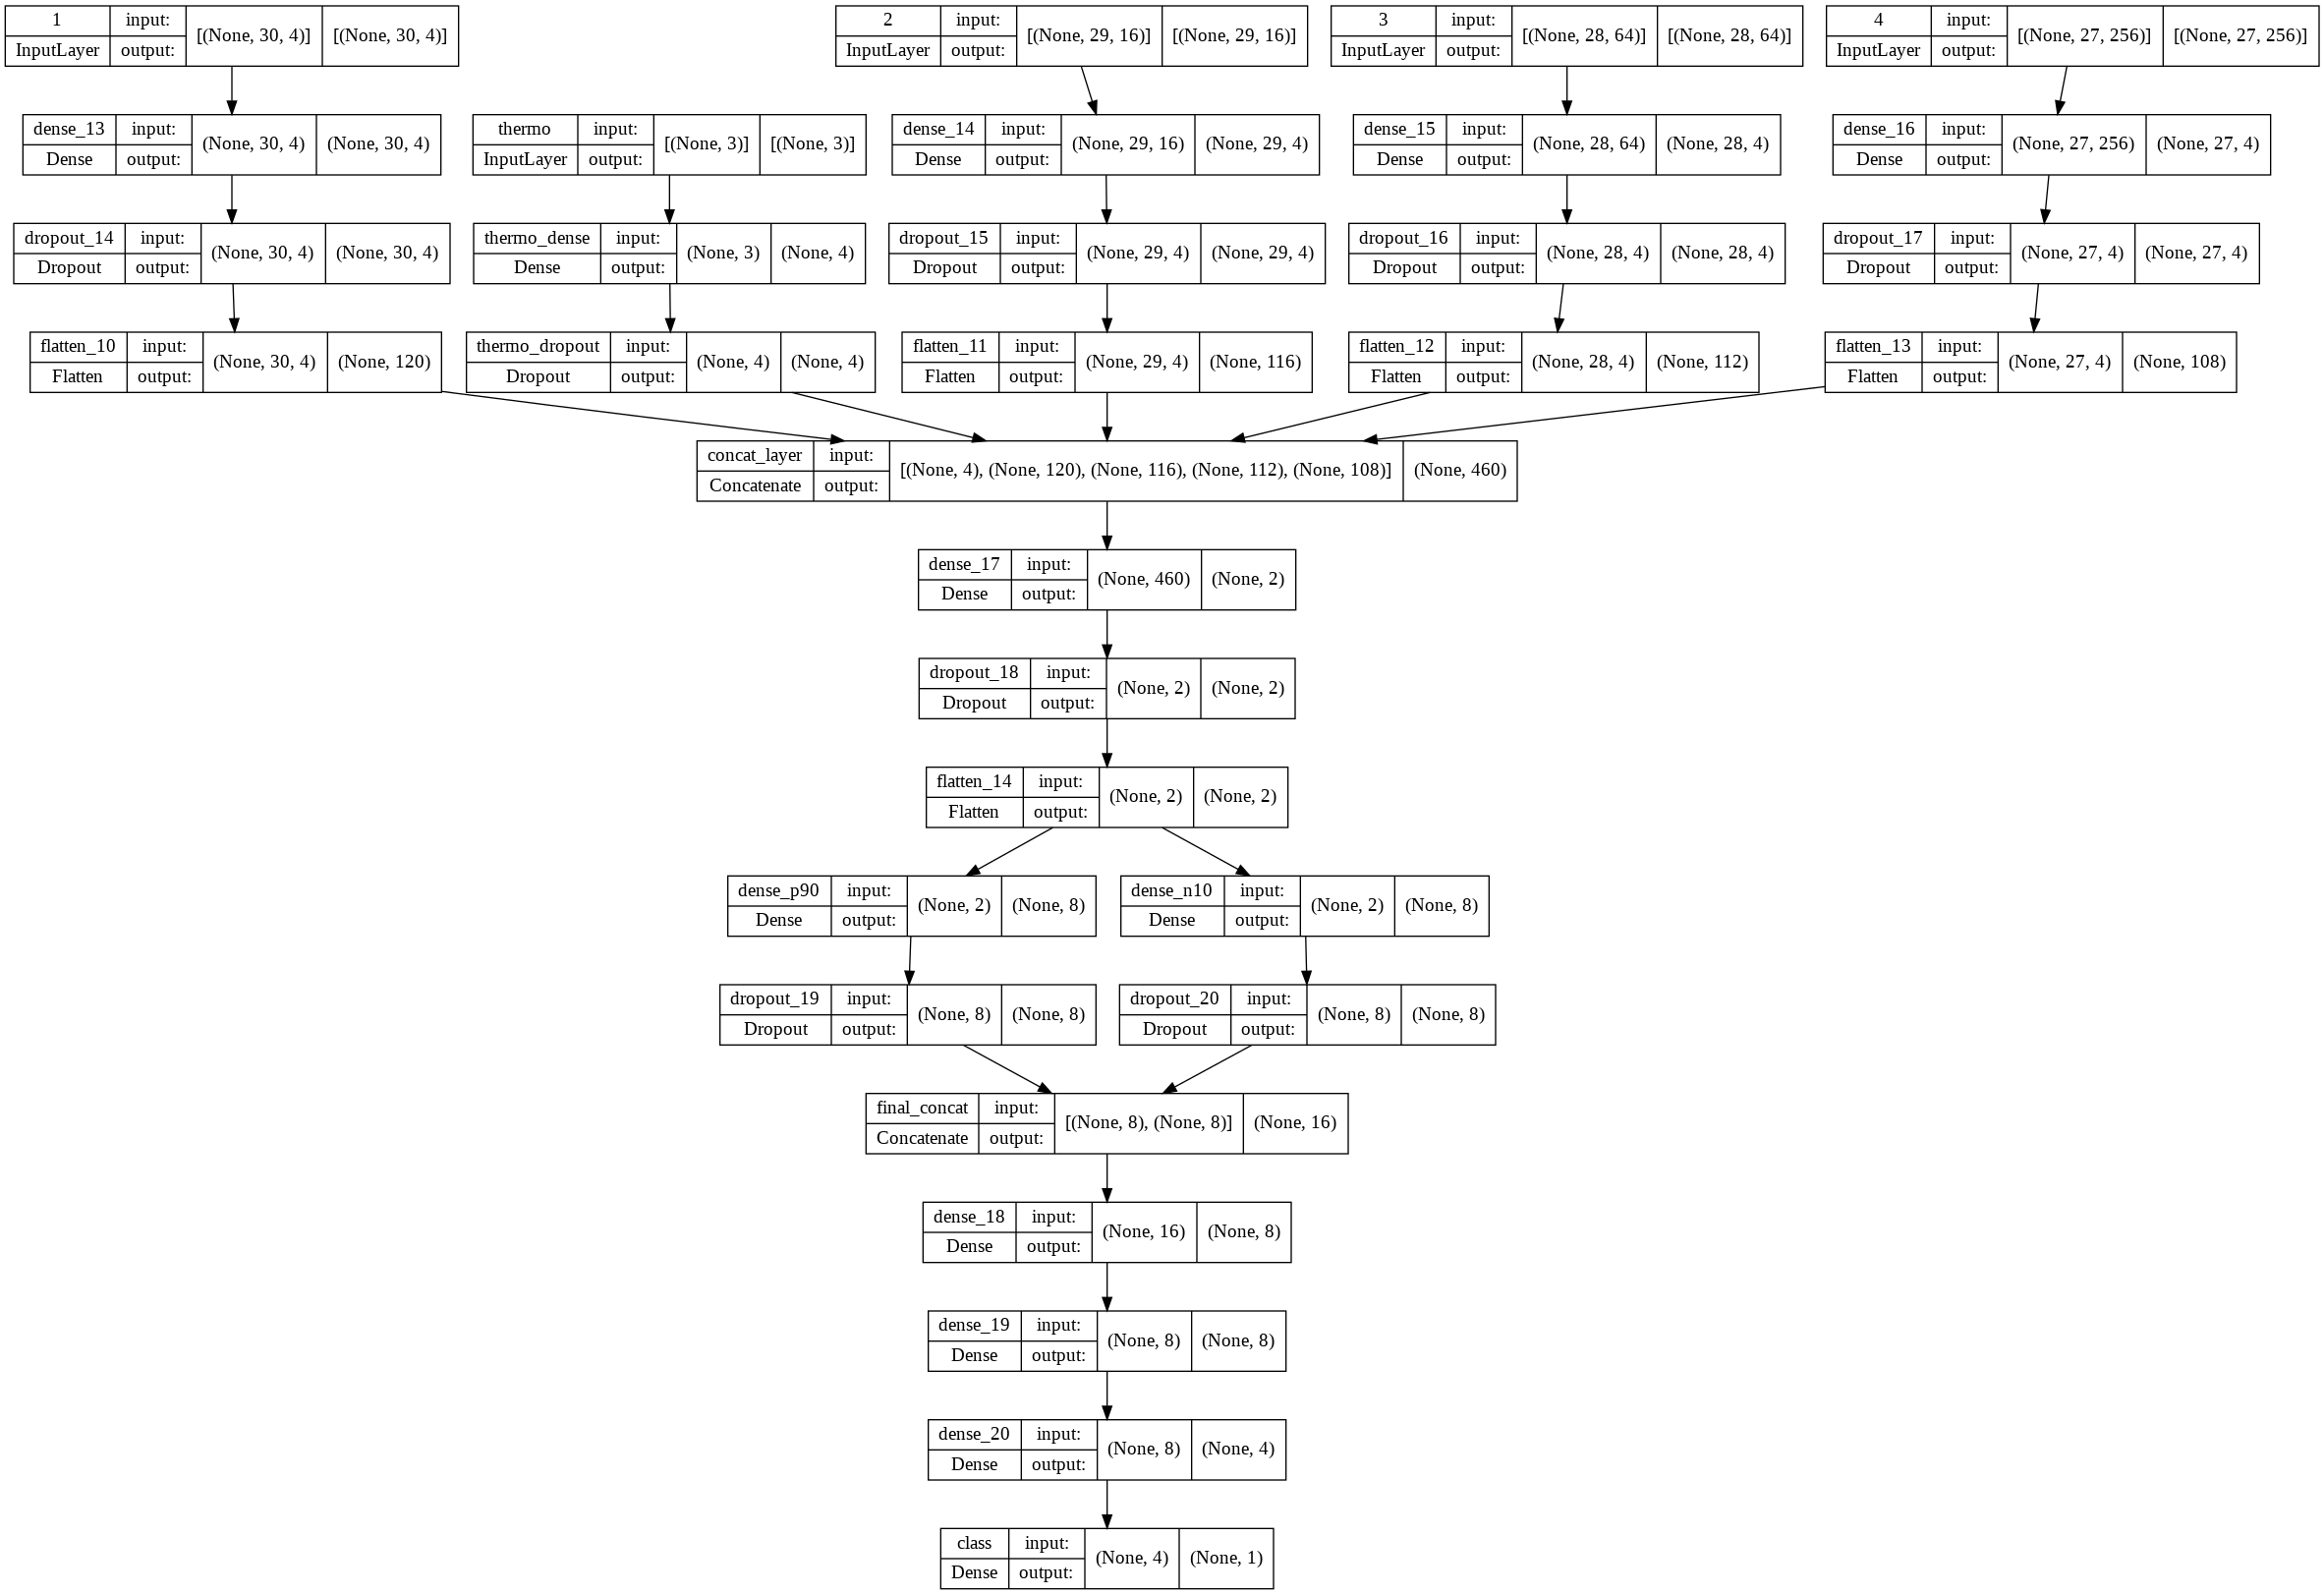

In [ ]:
tf.keras.utils.plot_model(model_class, to_file='model.png', show_shapes=True, show_layer_names=True)


# 10-cross validation



### Dividing the dataset in 10 chunks for the cross-validation



In [ ]:
ds = pd.read_csv('expar_dataset.txt', sep=' ', index_col='id')

ds = preprocessing()

ds = ds.sample(frac=1) # Mixes the ds

num_chunks = 10
chunk_size = ds.shape[0] // num_chunks

resto = ds.shape[0] % num_chunks

n_reg_chunks = num_chunks - resto

chunks = []

# Hay que dividir el dataset (204 samples) en 10 chunks. 6 de 20 samples y 4 de 21.

#Los primeros 6 chunks de 20 samples
for i in range(n_reg_chunks):
  

  chunks.append(ds[i*chunk_size:(i+1)*chunk_size])

#Los siguientes 4 chunks de 21 (chunk_size + 1) samples

for i in range(resto):
  start = n_reg_chunks * chunk_size
  resto_ds = ds[start:]

  chunks.append(resto_ds[i*(chunk_size+1):(i+1)*(chunk_size+1)])


### Performing the 10-cross validation

In [ ]:
acc_list = []
specificity_list = []
sensitivity_list = []

k_i = 1
k_f= 4
BATCH_SIZE = 64

for chunk_n in range(num_chunks):

  print('Validacion #'+ str(chunk_n+1))

  test_ds = chunks.pop(0)
  train_ds = pd.concat(chunks)
  # restores the ds chunks list
  chunks.append(test_ds)

  test, _, _ , _, _ = gen_datasets(test_ds,
                                   'class',
                                   k_i = k_i,
                                   k_f = k_f,
                                   BATCH_SIZE = BATCH_SIZE,
                                   validation_split = 0,
                                   training = False)
  

  model, _,_, _ = train_model_class(k_i = k_i,
                                    k_f = k_f,
                                    BATCH_SIZE = BATCH_SIZE,
                                    verbose = 0,
                                    val_split = 0)

  # Evaluate modele and append to list of chunks acc
  model_accuracy = model.evaluate(test, batch_size=BATCH_SIZE, verbose=1)[1]
  acc_list.append(model_accuracy)


  # Confusion Matrix
  pred_binary = np.where((model.predict(test) <= 0.5) , 0, 1).reshape(-1)
  cm = tf.math.confusion_matrix(
      test_ds['class'], pred_binary).numpy()

  print('Resultados validacion #'+ str(chunk_n+1))
  print('Accuracy: ' + str(round(model_accuracy*100,2)) + '%')

  actual_class = np.where(np.array(test_ds['class']) == 1, 'I', 'II')
  pred_binary = np.where(pred_binary == 1, 'I', 'II')

  print('Confusion Matrix\n')
  data = {'y_Actual': actual_class,
          'y_Predicted': pred_binary
          }

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

  print(confusion_matrix,'\n')

  specificity = cm[0,0]/ np.sum(cm, axis = 1)[0]
  specificity_list.append((cm[0,0],np.sum(cm, axis = 1)[0]))
  print('Specificity = '+ str(round(specificity*100,2))+'%')

  sensitivity = cm[1,1]/np.sum(cm, axis = 1)[1]
  sensitivity_list.append((cm[1,1],np.sum(cm, axis = 1)[1]))
  print('Sensitivity = '+ str(round(sensitivity*100,2))+'%')
  print('\n\n')

print('~~~~~~~ RESULTADOS FINALES ~~~~~~~')

sum_pos = 0 
sum_total = 0
for pos, total in specificity_list:
  sum_pos += pos
  sum_total += total

select_total = round(sum_pos*100/sum_total, 2)

sum_pos = 0 
sum_total = 0
for pos, total in sensitivity_list:
  sum_pos += pos
  sum_total += total

sens_total = round(sum_pos*100/sum_total, 2)

print('Accuracy = ' + str(round(np.mean(acc_list)*100,2)) + '%')

print('Overall specificity = ' + str(select_total) + '%')
print('Overall sensitivity = ' + str(sens_total) + '%')

Validacion #1
1/1 [==============================] - 0s 446ms/step - loss: 0.5231 - accuracy: 0.8500
Resultados validacion #1
Accuracy: 85.0%
Confusion Matrix

Predicted  I  II
Actual          
I          8   1
II         2   9 

Specificity = 81.82%
Sensitivity = 88.89%



Validacion #2
1/1 [==============================] - 0s 436ms/step - loss: 0.2507 - accuracy: 0.9500
Resultados validacion #2
Accuracy: 95.0%
Confusion Matrix

Predicted   I  II
Actual           
I          10   0
II          1   9 

Specificity = 90.0%
Sensitivity = 100.0%



Validacion #3
1/1 [==============================] - 0s 467ms/step - loss: 0.6386 - accuracy: 0.6500
Resultados validacion #3
Accuracy: 65.0%
Confusion Matrix

Predicted  I  II
Actual          
I          9   0
II         7   4 

Specificity = 36.36%
Sensitivity = 100.0%



Validacion #4
1/1 [==============================] - 0s 465ms/step - loss: 0.3681 - accuracy: 0.9000
Resultados validacion #4
Accuracy: 90.0%
Confusion Matrix

Predicted   